In [26]:
import requests
import json
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np
import locale

In [27]:
df = pd.read_csv("velib_data_with_date.csv", index_col=0)

df.legible_last_reported = df.legible_last_reported.apply(datetime.fromisoformat)
df.lastUpdated = df.lastUpdated.apply(datetime.fromisoformat)
df.date_retrieved = df.date_retrieved.apply(datetime.fromisoformat)

In [32]:
df["day_hour_of_week_num"] = df["date_retrieved"].apply(lambda x: 100 * x.weekday() + x.hour)

locale.setlocale(locale.LC_TIME, "fr_FR")
df["Jour et heure"] = df["date_retrieved"].apply(lambda x: datetime.strftime(x, "%A %Hh"))

locale.setlocale(locale.LC_TIME, "en_US")
df["Time"] = df["date_retrieved"].apply(lambda x: datetime.strftime(x, "%A %I%p"))


In [33]:
req = requests.get("https://velib-metropole-opendata.smoove.pro/opendata/Velib_Metropole/station_information.json")
loc_stations_data = req.json()["data"]["stations"]

In [34]:
loc_stations_df = pd.DataFrame(loc_stations_data)
loc_stations_df["rental_methods_str"] = loc_stations_df.rental_methods.apply(lambda x: x[0] if type(x) == list else "Aucun")

In [35]:
loc_stations_df["rental_methods_str"].unique()

array(['Aucun', 'CREDITCARD'], dtype=object)

In [36]:
df_geo = df.merge(loc_stations_df, on="station_id")
df_geo = df_geo.sort_values(by='last_reported') 
df_geo["date"] = df_geo.legible_last_reported.astype(str)
df_geo.columns

Index(['stationCode_x', 'station_id', 'num_bikes_available',
       'num_docks_available', 'is_installed', 'is_returning', 'is_renting',
       'last_reported', 'num_mech_bikes_available', 'num_ebikes_available',
       'legible_last_reported', 'functioning_word', 'lastUpdated',
       'date_retrieved', 'day_hour_of_week_num', 'Jour et heure', 'Time',
       'name', 'lat', 'lon', 'capacity', 'stationCode_y', 'rental_methods',
       'rental_methods_str', 'date'],
      dtype='object')

In [37]:
df_geo["diff_ebikes"] = df_geo.groupby(by=['stationCode_x']).num_ebikes_available.diff()
df_geo["diff_mech_bikes"] = df_geo.groupby(by=['stationCode_x']).num_mech_bikes_available.diff()
df_geo["diff_bikes"] = df_geo.groupby(by=['stationCode_x']).num_bikes_available.diff()

In [38]:
df_geo["occupancy"] = df_geo.num_bikes_available/df_geo.capacity
df_geo["occupancy_mech"] = df_geo.num_mech_bikes_available/df_geo.capacity
df_geo["occupancy_ebikes"] = df_geo.num_ebikes_available/df_geo.capacity
df_geo["frac_mech"] = df_geo.num_mech_bikes_available/df_geo.num_bikes_available
df_geo["frac_ebikes"] = df_geo.num_ebikes_available/df_geo.num_bikes_available

## API Error

In [39]:
grouped_df = df_geo.groupby(["name", "last_reported"]).agg({"num_bikes_available": "nunique"}).reset_index()
grouped_df[grouped_df.num_bikes_available>9]

,name,last_reported,num_bikes_available
19603,Fille du Calvaire - Turenne,1631024917,10
19654,Filles Saint-Thomas - Place de la Bourse,1631024985,10
26392,Guynemer - Jardin du Luxembourg,1631024957,10
61146,Saint-Germain-des-Prés,1631024979,10
67039,Traversière - Ledru-Rollin,1631024654,10


In [40]:
dff = df_geo[df_geo.name == "Fille du Calvaire - Turenne"]
dff

,stationCode_x,station_id,num_bikes_available,num_docks_available,is_installed,is_returning,is_renting,last_reported,num_mech_bikes_available,num_ebikes_available,...,rental_methods_str,date,diff_ebikes,diff_mech_bikes,diff_bikes,occupancy,occupancy_mech,occupancy_ebikes,frac_mech,frac_ebikes
165128,3003,96608796,7,18,1,1,1,1630924060,4,3,...,CREDITCARD,2021-09-06 12:27:40,NaN,NaN,NaN,0.241379,0.137931,0.103448,0.571429,0.428571
165130,3003,96608796,8,17,1,1,1,1630924122,5,3,...,CREDITCARD,2021-09-06 12:28:42,0.0,1.0,1.0,0.275862,0.172414,0.103448,0.625000,0.375000
165129,3003,96608796,7,18,1,1,1,1630924122,4,3,...,CREDITCARD,2021-09-06 12:28:42,0.0,-1.0,-1.0,0.241379,0.137931,0.103448,0.571429,0.428571
165131,3003,96608796,9,16,1,1,1,1630924122,6,3,...,CREDITCARD,2021-09-06 12:28:42,0.0,2.0,2.0,0.310345,0.206897,0.103448,0.666667,0.333333
165132,3003,96608796,10,15,1,1,1,1630924122,6,4,...,CREDITCARD,2021-09-06 12:28:42,1.0,0.0,1.0,0.344828,0.206897,0.137931,0.600000,0.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165277,3003,96608796,5,20,1,1,1,1631082574,2,3,...,CREDITCARD,2021-09-08 08:29:34,1.0,1.0,2.0,0.172414,0.068966,0.103448,0.400000,0.600000
165278,3003,96608796,4,21,1,1,1,1631082574,1,3,...,CREDITCARD,2021-09-08 08:29:34,0.0,-1.0,-1.0,0.137931,0.034483,0.103448,0.250000,0.750000
165280,3003,96608796,7,18,1,1,1,1631086253,3,4,...,CREDITCARD,2021-09-08 09:30:53,1.0,2.0,3.0,0.241379,0.103448,0.137931,0.428571,0.571429
165279,3003,96608796,5,20,1,1,1,1631086253,3,2,...,CREDITCARD,2021-09-08 09:30:53,-2.0,0.0,-2.0,0.172414,0.103448,0.068966,0.600000,0.400000


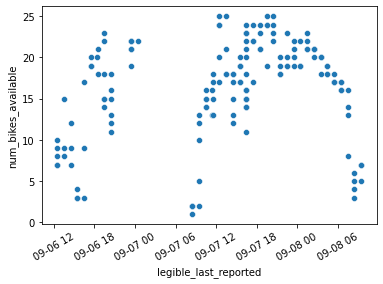

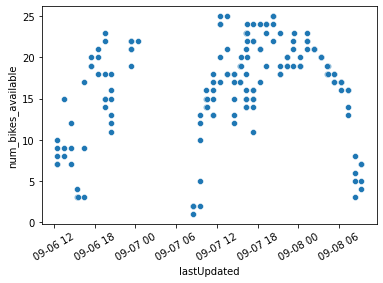

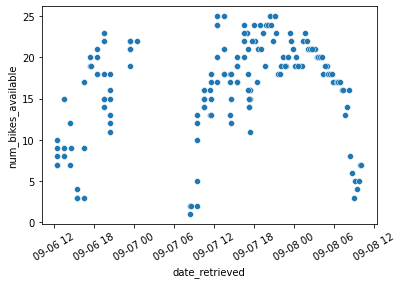

In [41]:
sns.scatterplot(data=dff, x="legible_last_reported", y="num_bikes_available")
plt.xticks(rotation=30);
plt.show()
sns.scatterplot(data=dff, x="lastUpdated", y="num_bikes_available")
plt.xticks(rotation=30);
plt.show()
sns.scatterplot(data=dff, x="date_retrieved", y="num_bikes_available")
plt.xticks(rotation=30);
plt.show()

## Clustering

In [42]:
df_geo.columns

Index(['stationCode_x', 'station_id', 'num_bikes_available',
       'num_docks_available', 'is_installed', 'is_returning', 'is_renting',
       'last_reported', 'num_mech_bikes_available', 'num_ebikes_available',
       'legible_last_reported', 'functioning_word', 'lastUpdated',
       'date_retrieved', 'day_hour_of_week_num', 'Jour et heure', 'Time',
       'name', 'lat', 'lon', 'capacity', 'stationCode_y', 'rental_methods',
       'rental_methods_str', 'date', 'diff_ebikes', 'diff_mech_bikes',
       'diff_bikes', 'occupancy', 'occupancy_mech', 'occupancy_ebikes',
       'frac_mech', 'frac_ebikes'],
      dtype='object')

In [108]:
group_by_geo_df = df_geo.groupby(by=['name', "lat", "lon", "day_hour_of_week_num"]).agg({'num_bikes_available':np.mean}).reset_index("day_hour_of_week_num")

#group_by_geo_df = group_by_geo_df.sort_values(by="day_hour_of_week_num")
dataset = []
labels = []
for id_ in group_by_geo_df.index.unique():
    name = id_[0]
    x = group_by_geo_df.loc[name].num_bikes_available.to_numpy()
    
    # Normalize 
    
    
    if x.shape[0] == 38:
        if x.max():
            x /= x.max()
        else:
            print(name, x)
        labels.append(name)
        dataset.append(x)
    else:
        pass #print(x.shape[0])
        
labels = np.array(labels)
dataset = np.array(dataset)
group_by_geo_df = group_by_geo_df.reset_index()


Bons Raisins - Voltaire [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Capitaine Glarner - Gabriel Péri [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Carnot - Général Lanrezac [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [109]:
from sklearn.cluster import KMeans, SpectralClustering
algo = KMeans(n_clusters=3, random_state=0).fit(dataset)
labels_clustering = algo.labels_

In [123]:
!pip install -U scikit-learn

  Using cached scikit_learn-0.24.2-cp38-cp38-macosx_10_13_x86_64.whl (7.2 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.2
    Uninstalling scikit-learn-0.23.2:
      Successfully uninstalled scikit-learn-0.23.2


In [131]:
from tslearn.clustering import TimeSeriesKMeans
model = TimeSeriesKMeans(n_clusters=3, metric="softdtw", max_iter=10)
model.fit(dataset)

TimeSeriesKMeans(max_iter=10, metric='softdtw')

In [132]:
labels_clustering = model.labels_

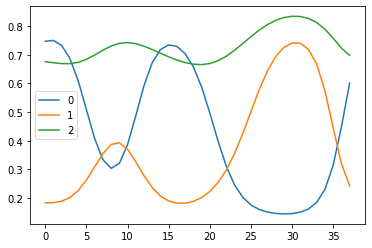

In [133]:
for i, center in enumerate(model.cluster_centers_):
    plt.plot(center, label=i)
    
plt.legend()

In [134]:
labels.shape

(1371,)

In [137]:
group_by_geo_df = df_geo.groupby(by=['name', "lat", "lon"]).agg({'num_bikes_available':np.mean}).reset_index()

In [138]:
fig = px.scatter_mapbox(group_by_geo_df[group_by_geo_df.name.isin(labels)], lat="lat", lon="lon", 
                        color = labels_clustering, size='num_bikes_available',
                        hover_name="name", 
                        zoom=11) 
                       # animation_frame="date", animation_group="name")
fig.update_layout(title="ff", mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [ ]:

fig = px.scatter_mapbox(df_geo, lat="lat", lon="lon", color = 'num_ebikes_available', size='capacity',
                        size_max=6, color_continuous_scale=px.colors.sequential.solar,
                        hover_name="name", hover_data=["num_bikes_available", "day_hour_of_week"],
                        zoom=11) 
                       # animation_frame="date", animation_group="name")
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [ ]:
fig = px.density_mapbox(group_by_geo_df, lat="lat", lon="lon", z = 'num_ebikes_available', #size='capacity',
                        color_continuous_scale=px.colors.sequential.solar,
                        hover_name="name", hover_data=["num_bikes_available", "day_hour_of_week"],
                        zoom=11, range_color=[0, group_by_geo_df.num_ebikes_available.max()],
                        animation_frame="day_hour_of_week", animation_group="name")
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [ ]:
fig = px.scatter_mapbox(group_by_geo_df, lat="lat", lon="lon", color = 'num_ebikes_available', size='num_bikes_available',
                        color_continuous_scale=px.colors.sequential.solar,
                        hover_name="name", hover_data=["num_bikes_available", "day_hour_of_week"],
                        zoom=11, width=800,
                        animation_frame="day_hour_of_week", animation_group="name")
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [ ]:
diff_df_pos = group_by_geo_df[(~group_by_geo_df.diff_ebikes.isna())&(group_by_geo_df.diff_ebikes!=0)]
diff_df_pos = group_by_geo_df[group_by_geo_df.diff_ebikes>0]
diff_df_neg = group_by_geo_df[group_by_geo_df.diff_ebikes<0]

fig_diff = px.density_mapbox(diff_df_neg, lat="lat", lon="lon", z = "diff_ebikes", radius=6*np.abs(diff_df_neg.diff_ebikes.to_numpy()),
                        color_continuous_scale='reds_r',  
                        hover_name="name", hover_data=["num_bikes_available", "day_hour_of_week"],
                        zoom=11, color_continuous_midpoint=0,width=800,range_color=[-12, 0],
                        animation_frame="day_hour_of_week", animation_group="name")
# fig_diff = px.density_mapbox(diff_df_pos, lat="lat", lon="lon", z = "diff_ebikes", radius=6*np.abs(diff_df_pos.diff_ebikes.to_numpy()),
#                         color_continuous_scale='blues',  
#                         hover_name="name", hover_data=["num_bikes_available", "day_hour_of_week"],
#                         zoom=11, color_continuous_midpoint=0,width=800,range_color=[0,12],
#                         animation_frame="day_hour_of_week", animation_group="name")

fig_diff.update_layout(mapbox_style="carto-positron")
fig_diff.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig_diff.show()

In [ ]:
fig_diff = px.scatter_mapbox(diff_df, lat="lat", lon="lon", color = "diff_ebikes", size=6*np.abs(diff_df.diff_ebikes.to_numpy()),
                        color_continuous_scale='Bluered_r',  
                        hover_name="name", hover_data=["num_bikes_available", "day_hour_of_week"],
                        zoom=11, color_continuous_midpoint=0,width=800,range_color=[-12, 12],
                        animation_frame="day_hour_of_week", animation_group="name")

fig_diff.update_layout(mapbox_style="carto-positron")
fig_diff.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig_diff.show()

In [ ]:
import dash
from dash import dcc
from dash import html

app = dash.Dash()
app.layout = html.Div(children=[
    html.H1(children='Velib Visualisation'),
    
    
    html.Div(
        [html.Label('Type of bikes'),
        dcc.Dropdown(
            options=[
                {'label': 'All bikes', 'value': 'all_bikes'},
                {'label': 'Electric Bikes', 'value': 'ebikes'},
                {'label': 'Mechanical bikes', 'value': 'mech_bikes'}
            ],
            value='all_bikes'
        )],
        style={'width':'20%', 'display': 'inline-block'})
    ,
    html.Div(
        [html.Label('Language'),
        dcc.Dropdown(
            options=[
                {'label': u'Français', 'value': 'FR'},
                {'label': 'English', 'value': 'EN'}
            ],
            value='EN'
        )],
        style={'width':'10%', 'display': 'inline-block'})
    ,

    dcc.Graph(
        id='velo',
        figure=fig
    )
#         dcc.Graph(
#         id='diff_df',
#         figure=fig_diff
#     )
])

app.run_server(host = '127.0.0.1', debug=False, use_reloader=False)  # Turn off reloader if inside Jupyter

In [ ]:
count_type_time = group_by_geo_df.groupby(by="day_hour_of_week").agg({'num_bikes_available':sum,
                                                             'num_docks_available':sum,
                                                             'num_mech_bikes_available':sum, 
                                                             'num_ebikes_available':sum, 
                                                             'capacity':sum}).reset_index()


In [ ]:
px.bar(count_type_time, x="day_hour_of_week", y=["capacity"]).show()
px.bar(count_type_time, x="day_hour_of_week", y=["num_bikes_available", 'num_docks_available']).show()
px.bar(count_type_time, x="day_hour_of_week", y=["num_ebikes_available", 'num_mech_bikes_available','num_docks_available'])